In [1]:
from model_bet import Graph_Diff_Reg
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import random, glob, time, os, pickle
import numpy as np
from graphcuda import generate_random_adjacency_matrix, faq_align
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The following device is used: '+str(device))

The following device is used: cuda


In [42]:
hidden = 256
num_epoch = 200

n_features= 256#list_fm_train_shuffled[0].shape[1]
dropout_val = 0.2
learning_rate = 1e-6

model = Graph_Diff_Reg(input_dim=n_features,hidden_dim=hidden,output_dim=1,dropout=dropout_val)
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-7)

training_loss_epochs = []
training_mse_epochs = []

testing_loss_epochs= []
testing_mse_epochs= []

training_score_epochs = []
testing_score_epochs = []

In [43]:
def damage_graph(base_graph):
    G0=base_graph.copy()
    while True:
        tempg=base_graph.copy()
        ndel=list(np.random.randint(0,len(base_graph.edges())-1,random.randint(0,20)))
        ndel.sort(reverse=True)
        # ndel=i
        try:
            for j in range(len(ndel)):
                u,v=list(base_graph.edges())[ndel[j]][0:2]
                
                tempg.remove_edge(u, v)
            
            if nx.is_connected(tempg):
                for j in range(len(ndel)):
                    u,v=list(base_graph.edges())[ndel[j]][0:2]
                    # G0.remove_edge(u, v)
                    G0.edges[u,v]['weight'] = 1000000000
                break
            else:
                print("try again")
                continue
        except KeyError:
            continue
        except  nx.NetworkXError:
            continue
    # list_node_weights_train.append(np.random.random(max_node).reshape(1,-1))
    return G0.to_directed()

def get_fm_centrality(graph: nx.Graph):
    pfilename="test.edg"

    # ebc=nx.betweenness_centrality(g, weight = 'weight')
    total_sum_new=distance_sum(graph)
    # eff=total_sum_orig/total_sum_new
    
    centrality = total_sum_new
        
    # adj_mat = np.zeros((num_nodes,num_nodes))
    # adj_mat_excerpt = get_adj_matrix(g).todense()
    # adj_mat[0:adj_mat_excerpt.shape[0], 0:adj_mat_excerpt.shape[1]] = adj_mat_excerpt
    # adj_mat = sparse.csr_matrix(adj_mat)
    

    
    ndim = 256
    feature_mat = np.zeros((graph.number_of_nodes(),ndim))
    feature_mat_excerpt = get_node_embedding(graph, dimensions = ndim, walk_length = 50, num_walks = 50, workers = 12,pfilename=pfilename).todense()
    feature_mat[0:feature_mat_excerpt.shape[0]] = feature_mat_excerpt
    feature_mat = sparse.csr_matrix(feature_mat)

    # adj_mat = sparse_mx_to_torch_sparse_tensor(adj_mat)  

    feature_mat = sparse_mx_to_torch_sparse_tensor(feature_mat)

    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    edge_weight = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges])

    return edge_index, edge_weight, centrality, feature_mat

def get_centrality(graph):
    # ebc=nx.betweenness_centrality(g, weight = 'weight')
    total_sum_new=distance_sum(graph)
    # eff=total_sum_orig/total_sum_new
    centrality = total_sum_new
        
    # adj_mat = np.zeros((num_nodes,num_nodes))
    # adj_mat_excerpt = get_adj_matrix(g).todense()
    # adj_mat[0:adj_mat_excerpt.shape[0], 0:adj_mat_excerpt.shape[1]] = adj_mat_excerpt
    # adj_mat = sparse.csr_matrix(adj_mat)
    
    # adj_mat = sparse_mx_to_torch_sparse_tensor(adj_mat)  
    # list_adj.append(adj_mat)
    
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    edge_weight = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges])

    return edge_index, edge_weight, centrality

In [44]:
class GNNSample:
    def __init__(self, reference_graph, n_nodes, prob_edge):
        self.base_graph = generate_random_adjacency_matrix(n_nodes, prob_edge)
        self.base_graph = faq_align(reference_graph, self.base_graph, seed=123, max_iter=30)

        self.mod_graph = damage_graph(self.base_graph)

        self.base_graph = nx.from_numpy_array(self.base_graph)
        self.mod_graph = nx.from_numpy_array(self.mod_graph).to_directed()

        self.base_edge_index, self.base_edge_weight, self.base_centrality, self.base_fm = get_fm_centrality(self.base_graph)
        self.mod_edge_index, self.mod_edge_weight, self.mod_centrality, self.mod_fm = get_fm_centrality(self.mod_graph)

In [45]:
def train(filefolder):
    model.train() 
    
    loss_train = 0
    num_files_train = len(filefolder)
    
    starttime3 = time.time()
    y_trues=[]
    y_preds=[]
    
    random.shuffle(filefolder)
    n=0
    
    for i in range(num_files_train):
        print("Batch: "+str(i))

        filepath=filefolder[i]
        with open(filepath,"rb") as f:
            # list_adj_deg_train_shuffled, list_adj_wt_train_shuffled,list_num_edge_train, bc_mat_train_shuffled, list_fm_train_shuffled, list_n_seq_train, list_n_unshuffle_train,list_adj_deg_test_shuffled, list_adj_wt_test_shuffled,list_num_edge_test, bc_mat_test_shuffled, list_fm_test_shuffled, list_n_seq_test, list_n_unshuffle_test=pickle.load(f)
            graphs=pickle.load(f)
        
        # for j in range(len(list_train_graph)):
        #     print(len(list_train_graph[j].edges()))
        
        random.shuffle(graphs)
        
        for sample in graphs:
            
            # g=list_train_graph
            # adj2=torch.tensor(nx.adjacency_matrix(list_train_graph[j]).toarray()).numpy()
            
            # for 
            
            
            edge_index = sample.mod_edge_index
            edge_weigth = sample.mod_edge_weight
            
            # adj=torch.tensor(edge_list_to_adjacency_matrix(edge_index.numpy().transpose(), edge_weigth.numpy(), 500))
            # adj=adj.to(device)
            
            edge_index = edge_index.to(device)
            edge_weigth = edge_weigth.to(device)
            fm0 = sample.base_fm
            # fm=torch.tensor(np.eye(500,dtype=np.float32))
            
            batch_vector=np.zeros((fm0.shape[0]),dtype=np.int64)
            batch_vector=torch.tensor(batch_vector)
            batch_vector=batch_vector.to(device)
            
            fm0=fm0.to(device).to_dense()

            fm1 = sample.mod_fm
            # fm=torch.tensor(np.eye(500,dtype=np.float32))
            
            batch_vector=np.zeros((fm1.shape[0]),dtype=np.int64)
            batch_vector=torch.tensor(batch_vector)
            batch_vector=batch_vector.to(device)
            
            fm1=fm1.to(device).to_dense()
            # adj_orig=torch.tensor(nx.adjacency_matrix(list_train_graph_orig[j]).toarray())
            edge_index_orig = sample.base_edge_index
            edge_weigth_orig = sample.base_edge_weight
            
            # adj_orig=torch.tensor(edge_list_to_adjacency_matrix(edge_index_orig.numpy().transpose(), edge_weigth_orig.numpy(), 500))
            # adj_orig=adj_orig.to(device)
            
            # adjn=adj.cpu().numpy()
            # adjon=adj_orig.cpu().numpy()
            # adjr=adjon-adjn
            # adjr[adjr!=0]=1
            # adjr=torch.tensor(adjr.astype(np.float32)).to(device)
            
            # edge_index_n=edge_index.cpu().numpy()
            # edge_index_orig_n=edge_index_orig.cpu().numpy()
            # edge_weight_n=edge_weigth.cpu().numpy()
            # edge_weight_n[edge_weight_n<10000]=1
            # edge_weight_n[edge_weight_n!=1]=0
            # edge_mask=torch.tensor(edge_weight_n.astype(np.int64)).to(device)
            
            edge_index_orig=edge_index_orig.to(device)
            
            edge_weigth_orig=edge_weigth_orig.to(device)
            
            y_true=torch.tensor(float(sample.ratio_normalized)).reshape([1,1])
            y_true=y_true.to(device)
            
            # adj = list_adj_deg_train_shuffled[j]
            # num_nodes = list_num_edge_train[j]
            # adj_t = list_adj_wt_train_shuffled[j]
            # fm = list_fm_train_shuffled[j]
            # adj = adj.to(device)
            # adj_t = adj_t.to(device)
            # fm=fm.to(device)
            
            optimizer.zero_grad()
                
            # y_out = model(adj,adj_t,fm)
            y_out = model(edge_index,edge_weigth.float(),edge_index_orig,edge_weigth_orig.float(),fm0.float(), fm1.float(),batch_vector)#,adjr.float(),edge_mask)#,adj,adj_orig)
                        
            # true_arr = torch.from_numpy(bc_mat_train_shuffled[:,j]).float()
            # true_val = true_arr.to(device)
            
            # true_val_final = true_val[list_n_unshuffle_train[j]]
            # y_out_final = y_out[list_n_unshuffle_train[j]]
            
            # true_val_ultimate = true_val_final[:num_nodes]
            # y_out_ultimate = y_out_final[:num_nodes]
            
            mse = loss_fn(y_out, y_true)
            
            mse.backward()
            
            
            
            optimizer.step()
            
            y_trues.append(float(y_true))
            y_preds.append(float(y_out))
            
            
            # loss_rank = new_loss_cal(y_out_ultimate, true_val_ultimate, num_nodes, device, model_size)
            loss_train = loss_train + float(mse)
            n+=1
            
    mse_final=loss_train/n
    duration3 = time.time()-starttime3
    print("training time this epoch:"+str(duration3))
    print("training loss:"+str(loss_train))
    print("training rmse:"+str(np.sqrt(float(mse_final))))
    
    score=r2_score(y_trues, y_preds)
    print("Training_R_Squared:"+str(score))
    
    return loss_train,mse_final,score

In [46]:
num_epoch = 1000

from tqdm.auto import trange

filefolder = glob.glob('./graph_data_train_multiple.pickle')
print("Training")
print(f"Total Number of epoches: {num_epoch}")

t = trange(num_epoch)
for e in t:
    print(f"Epoch number: {e+1}/{num_epoch}")
    print("LR: "+str(learning_rate))
  
    
    train_loss,train_mse,train_score = train(filefolder)
    t.set_description(f'{train_score:.03e}')
    t.refresh()
    training_loss_epochs.append(train_loss)
    training_mse_epochs.append(train_mse)
    training_score_epochs.append(train_score)

Training
Total Number of epoches: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch number: 1/1000
LR: 1e-06
Batch: 0
training time this epoch:3.2100203037261963
training loss:104.16292679118487
training rmse:1.0206024044219417
Training_R_Squared:-102.89151582464207
Epoch number: 2/1000
LR: 1e-06
Batch: 0
training time this epoch:3.2862491607666016
training loss:103.32172765536234
training rmse:1.0164729590862824
Training_R_Squared:-102.05250908239155
Epoch number: 3/1000
LR: 1e-06
Batch: 0
training time this epoch:3.421039581298828
training loss:101.5781016186811
training rmse:1.0078596212701505
Training_R_Squared:-100.3134261212375
Epoch number: 4/1000
LR: 1e-06
Batch: 0
training time this epoch:2.83894681930542
training loss:100.41281683396664
training rmse:1.002061958333748
Training_R_Squared:-99.15117736546598
Epoch number: 5/1000
LR: 1e-06
Batch: 0
training time this epoch:2.6491472721099854
training loss:98.82617424521595
training rmse:0.9941135460560627
Training_R_Squared:-97.56867015618185
Epoch number: 6/1000
LR: 1e-06
Batch: 0
training time this epoch

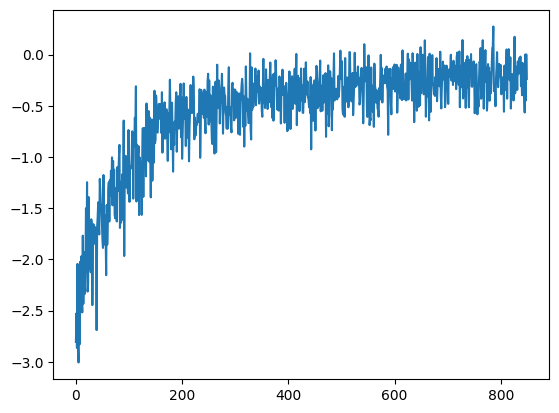

In [47]:
import matplotlib.pyplot as plt

# min(list(range(len(training_score_epochs))), key=lambda i: training_score_epochs[i])
plt.plot(training_score_epochs[150:])

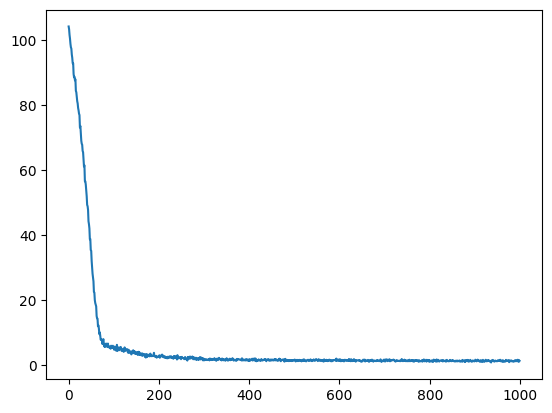

In [48]:
plt.plot(training_loss_epochs)